In [4]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [71]:
import pandas as pd
import torch
import numpy as np
import random
import re
import spacy
import shutil
import matplotlib.pyplot as plt
!pip install transformers
import torch.nn as nn
import torch.optim as optim
from transformers import AutoTokenizer, BertTokenizer, AutoModel, BertModel
from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split, RandomSampler, SequentialSampler
import time
from scipy.stats import spearmanr

In [72]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [73]:
path_base = '/content/drive/MyDrive/Tesis/SICK/transformer_tunned_BERT/uncase_base/study_optuna/'
file_root = '/content/drive/MyDrive/Tesis/SICK/uncase_based/SICK.txt'
with open(file_root, 'r') as temp_f:
    # get No of columns in each line
    col_count = [ len(l.split("\t")) for l in temp_f.readlines() ]

In [74]:
def getSICKSents(filename='sts-train.csv', set_type='TRAIN', encoding='utf-8'):
  f = open(filename, 'r', encoding=encoding)
  s1, s2, target = [], [], []
  for i, line in enumerate(f):
    example = re.split(r'\t+', line)
    if i >= 1:
      if example[-1].strip() == set_type:
        s2.append(example[1])
        s1.append(example[2])
        target.append(float(example[4]))
  print("samples: {}".format(len(target)))
  return s1, s2, target

In [75]:
s1_train,s2_train,target_train = getSICKSents(file_root, 'TRAIN')

samples: 4439


In [76]:
s1_test,s2_test,target_test= getSICKSents(file_root, 'TEST')

samples: 4906


In [77]:
s1_dev,s2_dev,target_dev= getSICKSents(file_root, 'TRIAL')

samples: 495


In [78]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')

Device: cuda


In [79]:
BATCH_SIZE = 32
MAX_LEN = 128
CORPUS = 'SICK'
BERT_PATH = "bert-base-uncased"

In [80]:
TOKENIZER = BertTokenizer.from_pretrained(BERT_PATH, do_lower_case=True)

In [81]:
def encode_sents(sents1, sents2):
    input_ids_ = []
    attention_masks_ = []
    type_ids_ = []
    for i, sent1 in enumerate(sents1):
        encoded_dict = TOKENIZER.encode_plus(
                            sent1,                      # Sentence 1 to encode.
                            sents2[i],                  # Sentence 2 to encode.
                            add_special_tokens = True,  # Add '[CLS]' and '[SEP]'
                            truncation = True,
                            max_length = MAX_LEN,       # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                      )

        # Add the encoded sentence to the list.
        input_ids_.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks_.append(encoded_dict['attention_mask'])

        type_ids_.append(encoded_dict['token_type_ids'])
    return input_ids_, attention_masks_, type_ids_

In [82]:
def getEncodedTensors(s1, s2, labels):
    input_ids, attention_masks, type_ids = encode_sents(s1, s2)
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    type_ids = torch.cat(type_ids, dim=0)
    labels = torch.tensor(labels)
    return input_ids, attention_masks, type_ids, labels

In [83]:
input_ids_train,attention_masks_train,type_ids_train,labels_train = getEncodedTensors(s1_train,s2_train,target_train)

In [84]:
input_ids_eval, attention_masks_eval, type_ids_eval, labels_eval = getEncodedTensors(s1_dev, s2_dev, target_dev)

In [85]:
# Combine the training inputs into a TensorDataset.
train_dataset = TensorDataset(input_ids_train, attention_masks_train, type_ids_train, labels_train)
val_dataset = TensorDataset(input_ids_eval, attention_masks_eval, type_ids_eval, labels_eval)

In [86]:
# Create the DataLoaders for our training and test sets.
# We'll take training samples in random order.
torch.manual_seed(42)
train_loader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = BATCH_SIZE # Trains with this batch size.
            #num_workers=2
        )
torch.manual_seed(42)
val_loader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = BATCH_SIZE # Evaluate with this batch size.
            #num_workers=2
        )

In [87]:
# See first batch
#batch = next(iter(train_loader))
#print(batch[0]) # 0 -> input_ids , 1 -> attention_masks, 2 -> type_ids, 3 -> targets
#print(train_loader.batch_size) #tamaño del batch
print('Number of train batches: {}'.format(len(train_loader)))# número de batches
print('Number of evaluation batches: {}'.format(len(val_loader)))

Number of train batches: 139
Number of evaluation batches: 16


In [88]:
class BertBaseUncasedRegressor(nn.Module):
  def __init__(self, num_classes = 1, dropout=0.1, attentions=True, n_layers = 0):
      super().__init__()
      self.bert = BertModel.from_pretrained(BERT_PATH, output_attentions=attentions) #load the model
      # Return:
      # last_hidden_state.shape -> [batch_size, num_tokens_in_sequence,hidden_size] (bert_base hidden_size = 768)
      # pooler_output.shape -> [batch_size, hidden_size] se utiliza una capa de pooling simple que aplica una transformación
      # lineal seguida de una función de activación tangente hiperbólica (tanh) a la última representación oculta (last_hidden_state) del token [CLS].
      layers = []
      for _ in range(n_layers):
          layers.append(nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size)) #self.bert.config.hidden_size -> nos da el tamaño oculto
          layers.append(nn.Dropout(dropout))
      layers.append(nn.Linear(self.bert.config.hidden_size, num_classes)) #self.bert.config.hidden_size -> nos da el tamaño oculto

      self.regressor = nn.Sequential(*layers)


  def forward(self, input_ids, type_ids, mask):
      bert_output =self.bert(input_ids=input_ids, token_type_ids = type_ids, attention_mask= mask)
      #output = bert_output.pooler_output
      output = bert_output.last_hidden_state[:, 0, :]
      logits = self.regressor(output)
      #logits = self.regressor(output_drop)
      return logits, bert_output

In [89]:
model = BertBaseUncasedRegressor(n_layers = 2, dropout=0.0152).to(device)

In [90]:
criterion = nn.MSELoss()
LEARNING_RATE = 2.152e-05#2.45e-05 #3.36e-5
optimizer = optim.RMSprop(model.parameters(), lr=LEARNING_RATE)

In [91]:
def pearson_corr(y_pred, y_true):
    all_preds = np.concatenate(y_pred)
    all_targets = np.concatenate(y_true)
    return np.corrcoef(all_preds, all_targets)[0, 1]

In [92]:
def spearman_corr(y_pred, y_true):
    all_preds = np.concatenate(y_pred)
    all_targets = np.concatenate(y_true)

    corr, _ = spearmanr(all_preds, all_targets)
    return corr

In [93]:
def train_loop(model,loader,optimizer,criterion,device,clip = 1.0):
    #Training loop
    model.train()
    loss_sum = 0
    all_preds = []
    all_targets = []
    seed = 42
    #np.random.seed(seed)
    #random.seed(seed)
    #torch.manual_seed(seed)
    #torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)



    for i, batch in enumerate(loader):

        b_input_ids = batch[0].to(device)
        b_attention_mask = batch[1].to(device)
        b_type_ids = batch[2].to(device)
        labels = batch[3].to(device)

        optimizer.zero_grad()
        #Forward
        outputs, _ = model(input_ids=b_input_ids, type_ids = b_type_ids, mask = b_attention_mask)
        outputs = outputs.squeeze(-1)
        #Loss
        loss = criterion(outputs.view(-1), labels.float())
        #Backprop
        loss.backward()
        #prevent gradients from exploding
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        #Update params
        optimizer.step()

        loss_sum += loss.item()

        all_preds.append(outputs.detach().cpu().numpy())
        all_targets.append(labels.float().detach().cpu().numpy())

    epoch_train_loss = loss_sum / len(loader)
    epoch_train_pearson = pearson_corr(all_preds, all_targets)
    epoch_train_spearman = spearman_corr(all_preds, all_targets)

    return epoch_train_loss, epoch_train_pearson, epoch_train_spearman


In [94]:
def evaluation_loop(model,loader,criterion,device):
    #Evaluation loop
    seed = 42
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)



    model.eval()
    with torch.no_grad():
        loss_sum = 0
        all_preds = []
        all_targets = []

        for i, batch in enumerate(loader):
            b_input_ids = batch[0].to(device)
            b_attention_mask = batch[1].to(device)
            b_type_ids = batch[2].to(device)
            labels = batch[3].to(device)

            #Forward
            outputs, _ = model(input_ids=b_input_ids, type_ids = b_type_ids, mask = b_attention_mask)
            outputs = outputs.squeeze(-1)
            #Loss
            loss = criterion(outputs.view(-1), labels.float())

            loss_sum += loss.item()

            all_preds.append(outputs.detach().cpu().numpy())
            all_targets.append(labels.float().detach().cpu().numpy())

        epoch_dev_loss = loss_sum / len(loader)
        epoch_dev_pearson = pearson_corr(all_preds, all_targets)
        epoch_dev_spearman = spearman_corr(all_preds, all_targets)

    return epoch_dev_loss, epoch_dev_pearson, epoch_dev_spearman

In [37]:
NUM_EPOCHS = 5
best_valid_loss = float('inf')
MODEL_FILE_NAME = CORPUS+'_'+BERT_PATH+'_'+str(MAX_LEN)+'_tunned_model.pt'
history = {"train": {"loss": []}, "val": {"loss": []}}

torch.cuda.empty_cache()

seed = 42
#np.random.seed(seed)
#random.seed(seed)
#torch.manual_seed(seed)
#torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)



for epoch in range(NUM_EPOCHS):

    start_time = time.time()

    epoch_train_loss, epoch_train_pearson, epoch_train_spearman = train_loop(model,train_loader,optimizer,criterion,device)
    epoch_dev_loss, epoch_dev_pearson, epoch_dev_spearman = evaluation_loop(model,val_loader,criterion,device)

    elapsed_time = time.time() - start_time

    #nos quedamos con el modelo que tiene mejor pérdida de validación
    if epoch_dev_loss < best_valid_loss:
      best_valid_loss = epoch_dev_loss
      torch.save(model.state_dict(), MODEL_FILE_NAME)


    history["train"]["loss"].append(epoch_train_loss)
    history["val"]["loss"].append(epoch_dev_loss)

    print('-' * 80)
    print(f'Epoch: {epoch+1:03}/{NUM_EPOCHS} | Time: {elapsed_time:.4f}s | Train loss: {epoch_train_loss:.4f} | Dev loss: {epoch_dev_loss:.4f}')
    print(f'Train Pearson Coef: {epoch_train_pearson:.4f} | Dev Pearson Coef: {epoch_dev_pearson:.4f}')
    print(f'Train Spearman Coef: {epoch_train_spearman:.4f} | Dev Spearman Coef: {epoch_dev_spearman:.4f}')

--------------------------------------------------------------------------------
Epoch: 001/5 | Time: 85.4045s | Train loss: 0.7376 | Dev loss: 0.3325
Train Pearson Coef: 0.6229 | Dev Pearson Coef: 0.8568
Train Spearman Coef: 0.5531 | Dev Spearman Coef: 0.8196
--------------------------------------------------------------------------------
Epoch: 002/5 | Time: 90.6054s | Train loss: 0.2186 | Dev loss: 0.3603
Train Pearson Coef: 0.8911 | Dev Pearson Coef: 0.8761
Train Spearman Coef: 0.8329 | Dev Spearman Coef: 0.8184
--------------------------------------------------------------------------------
Epoch: 003/5 | Time: 90.3118s | Train loss: 0.1301 | Dev loss: 0.3293
Train Pearson Coef: 0.9366 | Dev Pearson Coef: 0.8791
Train Spearman Coef: 0.9014 | Dev Spearman Coef: 0.8282
--------------------------------------------------------------------------------
Epoch: 004/5 | Time: 90.3504s | Train loss: 0.0825 | Dev loss: 0.3397
Train Pearson Coef: 0.9604 | Dev Pearson Coef: 0.8771
Train Spearm

TEST

In [124]:
model.load_state_dict(torch.load(MODEL_FILE_NAME, map_location=torch.device(device)))

input_ids_test, attention_masks_test, type_ids_test, labels_test = getEncodedTensors(s1_test, s2_test, target_test)
test_dataset = TensorDataset(input_ids_test, attention_masks_test, type_ids_test, labels_test)

torch.manual_seed(42)
test_iterator = DataLoader(
                test_dataset, # The validation samples.
                sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
                batch_size = BATCH_SIZE # Evaluate with this batch size.
                #num_workers=2
                )

test_loss, test_pearson, test_spearman = evaluation_loop(model,test_iterator,criterion,device)
print(f'Test Loss: {test_loss:.3f}')
print(f'Test Pearson: {test_pearson:.3f}')
print(f'Test Spearman: {test_spearman:.3f}')

Test Loss: 0.275
Test Pearson: 0.879
Test Spearman: 0.820


In [125]:
test = list(zip(s1_test,s2_test,target_test))

In [ ]:
from google.colab import files
files.download('/content/'+MODEL_FILE_NAME)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [136]:
def similarity_test(test_dataset, num_example, model, device):

    sents1, sents2, targets = zip(*test_dataset)
    print("Sent 1: ", sents1[num_example])
    print("Sent 2: ", sents2[num_example])
    encode_inputs, encode_att_mask, encode_type = encode_sents([sents1[num_example]], [sents2[num_example]])

    input_ids_test = torch.cat(encode_inputs, dim=0)
    attention_masks_test = torch.cat(encode_att_mask, dim=0)
    type_ids_test = torch.cat(encode_type, dim=0)
    labels_test = torch.tensor(targets[num_example])

    #ejecución de encoder con oración origen y máscara origen
    with torch.no_grad():
        output, bert = model(input_ids=input_ids_test.to(device), type_ids = type_ids_test.to(device), mask = attention_masks_test.to(device))
        output =output.squeeze(1)
        #attention
        # Obtener los pesos de atención para la primera capa de atención
        #attention_weights = bert.attentions[attention_layer]
    print("Predicted Class: ", round(output.item(),3))
    print("Target Class: ", round(labels_test.item(),3))
    return sents1[num_example], sents2[num_example], bert, input_ids_test


In [137]:
example = 5
s1, s2, bert, inputs = similarity_test(test, example, model, device)

Sent 1:  There is no dog wrestling and hugging
Sent 2:  Two dogs are wrestling and hugging
Predicted Class:  3.699
Target Class:  3.3


In [138]:
def trim_attention(att, input_ids):
    # Obtener la longitud de la secuencia de entrada sin el relleno
    input_len = np.count_nonzero(input_ids != 0)

    # Recortar la atención para eliminar el relleno
    att_trimmed = att[:, :input_len, :input_len]

    # Normalizar la atención para que las filas sumen 1
    att_trimmed = att_trimmed / att_trimmed.sum(axis=-1, keepdims=True)

    return att_trimmed

In [139]:
nlp_en = spacy.load("en_core_web_sm") # Pipeline en inglés
def view_attention(bert, input_ids, sentence1, sentence2, attention_layer):
    # Obtener los pesos de atención de la primera capa
    attention = bert.attentions[attention_layer][0].cpu().detach().numpy()
    # Recortar la matriz de atención
    att_trimmed = trim_attention(attention, input_ids)
    sentence = 'CLS ' + sentence1 + ' SEP ' + sentence2 + ' SEP'
    sent = [token.text for token in nlp_en(sentence)]
    # Visualizar la matriz de atención recortada
    plt.matshow(att_trimmed[-1], cmap='viridis')
    plt.xticks(np.arange(len(sent)), sent, rotation=90)
    plt.yticks(np.arange(len(sent)), sent)
    #plt.xlabel('Palabras de la primera oración')
    #plt.ylabel('Palabras de la segunda oración')
    #plt.title('Atención del modelo BERT para dos oraciones')
    plt.savefig('att.png', dpi=400, bbox_inches='tight')
    plt.show()

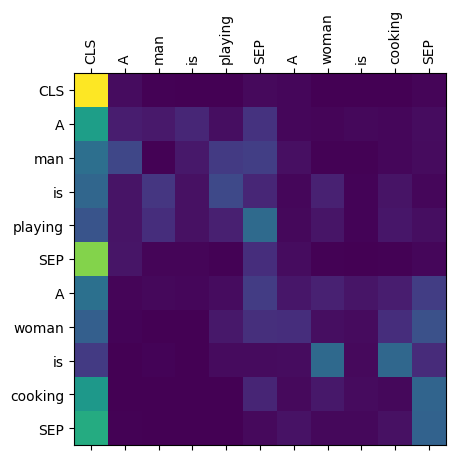

In [135]:
view_attention(bert, inputs, s1, s2, 0)

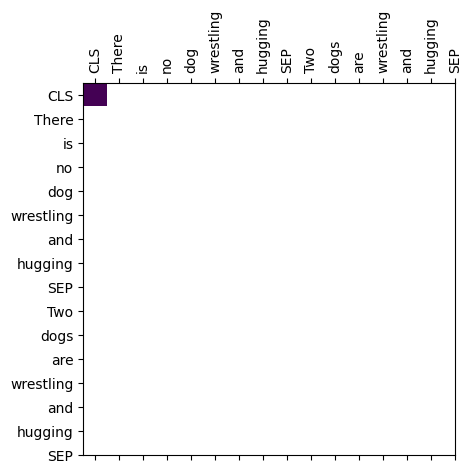

In [66]:
view_attention(bert, inputs, s1, s2, 6)

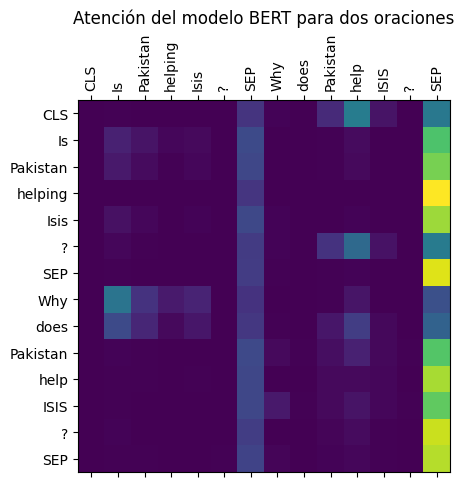

In [ ]:
view_attention(bert, inputs, s1, s2, 10)